<a href="https://colab.research.google.com/github/aubertsigouin/veille-tc/blob/main/Veille_0_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

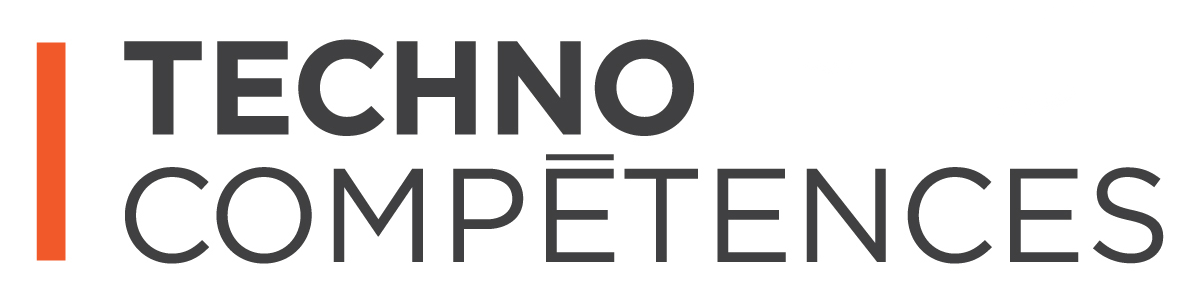

# Veille hebdomadaire



---


Exécution

1.   Cliquer ```Ctrl+F9``` **ou**
2.   Sélectionner ``` Exécuter tout``` dans l'onglet ``` Exécution``` **ou** 
3. Cliquer sur le bouton ```Play``` à gauche des 2 cellules masquées





In [ ]:
!pip install --quiet dateparser


import zipfile 

import pandas as pd
import requests
from bs4 import BeautifulSoup

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from lxml.html import fromstring
from lxml.html.clean import Cleaner
import string

import datetime
from datetime import timedelta
import dateparser

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

def is_current(date, hour):

    dateMin = datetime.datetime.now() - timedelta(hours=hour)
    dateMax = datetime.datetime.now() + timedelta(hours=24)
    
    try :
        parsed = dateparser.parse(
            date, 
            settings={'TIMEZONE': 'US/Eastern', 
                      'RETURN_AS_TIMEZONE_AWARE': False}
                      )
        if pd.to_datetime(dateMax) > parsed > pd.to_datetime(dateMin):
            return(True)
        else:
            return(False)
          
    except:
            return(None)

def clean(text):

    try:
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text).strip()
        doc = fromstring(cleantext)
        cleaner = Cleaner(style=True)
        text = cleaner.clean_html(doc).text_content()

        return(text)
    except:
        return('')

def strip_url(url):

    without_http = ''.join(url.split('//')[1:])
    just_domain = ''.join(without_http.split('/')[0])

    return(just_domain)

def preprocess(text):

    try:
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text).strip()
        doc = fromstring(cleantext)
        stops = stopwords.words('french')+stopwords.words('english')
        cleaner = Cleaner(style=True)
        text = cleaner.clean_html(doc).text_content()
        d = text.translate(str.maketrans('', '', string.punctuation)).lower()

        return(" ".join(x for x in d.split() if x not in stops))
    except:
        return('')

class Extractor():

    def __init__(self, links_path):
        self.liens = pd.read_csv(links_path, 
                                squeeze=True, usecols=['link'])
        
        print(f'Un extracteur a été initialisé.')
        print(f'{len(self.liens)} liens trouvés.')

    def get_todays_batch(self, threshold):

        descriptions = []
        dates = []
        article_urls = []
        exceptions = []

        for link in self.liens:
            try :
                requete = requests.get(link, timeout=5)    
            
            except:
                exceptions.append(link)
                pass

            requete.encoding = 'utf-8'
            news_feed = BeautifulSoup(requete.text,"lxml-xml")

            for article in news_feed.find_all('item'): 
                try :
                  descriptions.append(article.find('description').text)
                except:
                  descriptions.append('')
                try:
                  article_urls.append(article.find('link').text)
                except:
                  article_urls.append('')
                try :
                  dates.append(article.find('pubDate').text)
                except:
                  dates.append('')

        df = pd.DataFrame()
        df['domain'] = [strip_url(url) for url in article_urls]
        df['description'] = descriptions
        df['link'] = article_urls
        df['date'] = dates
        df['is_current'] = [is_current(date, threshold) for date in dates]

        print('Erreurs\n-------')
        print('\n'.join(exceptions))
        return(df[df['is_current']==True].reset_index(drop=True))

In [ ]:
# Unzip veille.zip
with zipfile.ZipFile('veille.zip', 'r') as zip_ref: 
  zip_ref.extractall()

# Start an extractor with links.csv
veille = Extractor(
    links_path = 'links.csv'
    )

df = veille.get_todays_batch(threshold=7*24) # Threshold changes timespan (hours) 

# Load unprocessed training data (descriptions and target)
descriptions = pd.read_csv('training_data.csv', sep=';', usecols=['description'])
target = pd.read_csv('training_data.csv', sep=';', usecols=['target'])

# Preprocess training descriptions
prep_desc = [preprocess(text) for text in descriptions['description']]

# Vectorize preprocessed training descriptions 
transformer = CountVectorizer(
    max_features=10000
    )

vectorized_train_desc = transformer.fit_transform(prep_desc)

# Instantiate two ML models
# Naive Bayesian
nb_model = MultinomialNB(
    alpha=0.01, 
    class_prior=None, 
    fit_prior=False
    )
# Random Forest, optimized by TPOT
rf_model = RandomForestClassifier(
    bootstrap=True, 
    criterion='entropy', 
    max_features=0.9500000000000001, 
    min_samples_leaf=2, 
    min_samples_split=4, 
    n_estimators=100
    )

# Train-test split vectorized training data
X_train, X_test, y_train, y_test = train_test_split(
    vectorized_train_desc, 
    target, 
    test_size=0.3,
    random_state=42)

# Fit algorithms with training data
nb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# 
prep_new_desc = [preprocess(text) for text in df['description']]
df['prep_description'] = prep_new_desc
vectorized_new_desc = transformer.transform(prep_new_desc)

df['domain'] = [strip_url(url) for url in df['link']]

df['nb_pred_proba'] = nb_model.predict_proba(vectorized_new_desc)[:,1]
df['rf_pred_proba'] = rf_model.predict_proba(vectorized_new_desc)[:,1]
df.loc[:,'mean_pred_proba'] = (df['nb_pred_proba'] + df['rf_pred_proba'])/2

df['description'] = [clean(text) for text in df['description']]
df = df.drop_duplicates(subset=['prep_description'])
df.drop('prep_description',axis=1)
df.drop('is_current',axis=1)


df.sort_values(by='mean_pred_proba', ascending=False).to_excel('new_predictions.xlsx')